<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/rice_seed_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# イネ種子計数形状解析

![rice image](https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/rice_seed_shape/rice.jpg?raw=true)
446粒分のイネ種子

## ライセンス
- 実行コードおよびイネ種子画像
    - CC-BY-NC4.0

## 解説
スマホやカメラを用いてイネ種子を撮影したとします。
この画像を用いて種子の計数（数える）や形状解析を行うプログラムを考えてみましょう。

背景が黒で、種子の色が明るいため、背景分離はグレースケール化を用いて簡単に行えそうです。また、隣の種と物理的に重なっていたり触っていたりしていない種子については、そのまま形状解析が可能に見えます。そうでない種子については、Watershedアルゴリズムなどの領域分割アルゴリズムで種子同士を分離できそうです。最後に検出ミスや遮蔽によって不完全な形の種を除く必要があります。楕円に近い形状のもののみを残せば、不要なデータやノイズは除去できそうです。以上のことを実現するためには下記の流れが考えられます。

1. グレースケール化
2. 任意もしくは自動閾値による背景分離
3. Watershedアルゴリズムによる分離
3. skimageのlabel, regionpropsによる領域計測
4. ノイズ除去
5. 任意の形状パラメーターの取得

## 実行コード

In [1]:
# 画像のダウンロード
!wget -O data/rice.jpg https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/rice_seed_shape/rice.jpg?raw=true

--2023-12-30 10:52:04--  https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/rice_seed_shape/rice.jpg?raw=true
github.com (github.com) をDNSに問いあわせています... 20.27.177.113
github.com (github.com)|20.27.177.113|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://github.com/phytometrics/plant_phenotyping_python/raw/main/notebooks/assets/rice_seed_shape/rice.jpg [続く]
--2023-12-30 10:52:04--  https://github.com/phytometrics/plant_phenotyping_python/raw/main/notebooks/assets/rice_seed_shape/rice.jpg
github.com:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/assets/rice_seed_shape/rice.jpg [続く]
--2023-12-30 10:52:05--  https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/assets/rice_seed_shape/rice.jpg
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 2606:50c0:8003::154, 2606:50c0

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from skimage.color import rgb2gray, label2rgb
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed

最初にwatershed無しでどれぐらいキレイに分割できるか試してみます。

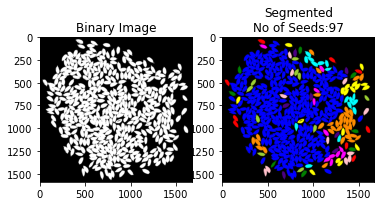

In [2]:
# 画像の読み込み
image = cv2.imread("data/rice.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 大津法による閾値の算出と背景分離
gray = rgb2gray(image)
threshold = threshold_otsu(gray)
# 閾値以上の明るさを物体、それ以外を背景としてbinary化
binary = gray > threshold

# 物体領域候補をラベル付けする
lbl_image = label(binary)

# 種子（候補）の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

# ラベル画像をカラー画像に変換
segmented = label2rgb(lbl_image, bg_label=0)

plt.subplot(121)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')

plt.subplot(122)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title("Segmented\nNo of Seeds:"+str(seed_no))
plt.show()

上記の右側の画像は種子の認識結果を示しています。異なる色は、それぞれ異なる種子として認識されたことを示しています。446粒の種子のうち、97領域しか単独で認識できず、大部分は複数の種子が固まった塊として認識されています。この状態では、形状解析を行うことは難しいでしょう。したがって、種子の境界を正確に認識し、それらを分割する新しい方法を導入する必要があります。

この問題を解決するために、画像解析の分野で広く用いられているWatershedアルゴリズムの導入を検討します。

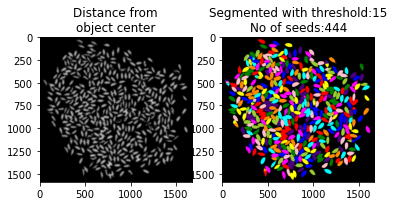

In [3]:
DISTANCE_THRESHOLD = 15

# 大津法にて背景分離を行います。
gray = rgb2gray(image)
threshold = threshold_otsu(gray)
binary = gray > threshold
# Distance transform to find markers for watershed
distance = ndi.distance_transform_edt(binary)
# Generate markers for the watershed
markers = label(distance > DISTANCE_THRESHOLD, connectivity=2)
# Apply watershed segmentation
lbl_image = watershed(-distance, markers, mask=binary)
# Convert label image to RGB image
segmented = label2rgb(lbl_image, bg_label=0)

# Count Seeds
# 種子の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

plt.subplot(121)
plt.imshow(distance, cmap='gray')
plt.title('Distance from\nobject center')

plt.subplot(122)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title('Segmented with threshold:'+ str(DISTANCE_THRESHOLD) + "\nNo of seeds:"+str(seed_no))
plt.show()

かなりの改善が見られました。DISTANCE_THRESHOLDの閾値を変えてみることで、それに伴った解析結果の変化が確認できます。

ただ、手動で値を変更し、最適な値を探索するのは大変です。0-30の間で検出可能な種子の数がどう変化するかプログラムに探索させてみましょう。


In [5]:
def get_seed_no_from_watershed(image, distance_threshold = 15):
    # 大津法にて背景分離を行います。
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    # Distance transform to find markers for watershed
    distance = ndi.distance_transform_edt(binary)
    # Generate markers for the watershed
    markers = label(distance > distance_threshold, connectivity=2)
    # Apply watershed segmentation
    lbl_image = watershed(-distance, markers, mask=binary)
    # Convert label image to RGB image
    segmented = label2rgb(lbl_image, bg_label=0)
    seed_no = len(np.unique(lbl_image)) - 1
    return seed_no, lbl_image, segmented

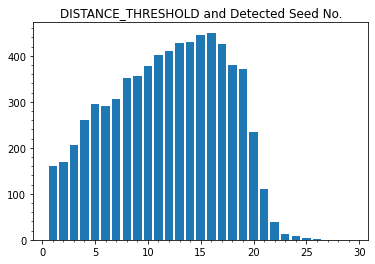

In [12]:
result = []
for i in range(1,30):
    # 種子数のみ結果を集めます。画像は使いません
    seed_no, _, _ = get_seed_no_from_watershed(image, distance_threshold=i)
    result.append([i,seed_no])

result = np.array(result)

plt.title("DISTANCE_THRESHOLD and Detected Seed No.")
plt.bar(result[:,0],result[:,1])

# 補助メモリ線の表示
plt.minorticks_on()

値が14~16のときに最も多くの領域を検出できていそうです。

**ただし、この値は検出された領域の総数であって、真の種子数と同義ではないことに注意しましょう。**
例えば、この数値には、過分割された種子も含まれます。

Text(0.5, 1.0, 'No of Seeds:444')

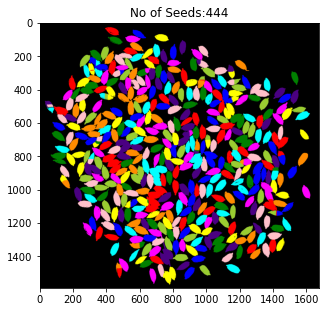

In [6]:
seed_no, lbl_image, segmented_image = get_seed_no_from_watershed(image, distance_threshold=15)
# Visualize the segmented regions
plt.figure(figsize=(5, 5))
plt.imshow(segmented_image, cmap='nipy_spectral')
plt.title("No of Seeds:"+str(seed_no))

この方法で単離された領域をもとに形状測定を行いましょう。

In [15]:
# 形状解析
# props = regionprops(lbl_image)
# 今回はみやすさのため、regionprops_tableを使います。

result = regionprops_table(lbl_image, properties=["area","axis_major_length","axis_minor_length", "eccentricity"])
df = pd.DataFrame(result)
df

,area,axis_major_length,axis_minor_length,eccentricity
0,2646.0,85.254134,41.015213,0.876669
1,2287.0,86.543921,34.237429,0.918420
2,2628.0,81.148629,41.565586,0.858857
3,2685.0,85.792475,40.327403,0.882636
4,2458.0,85.043518,37.942916,0.894954
...,...,...,...,...
439,2378.0,79.325459,38.784165,0.872326
440,1323.0,59.302412,30.449802,0.858110
441,2735.0,86.139815,40.850644,0.880397
442,4845.0,94.704422,71.343601,0.657644


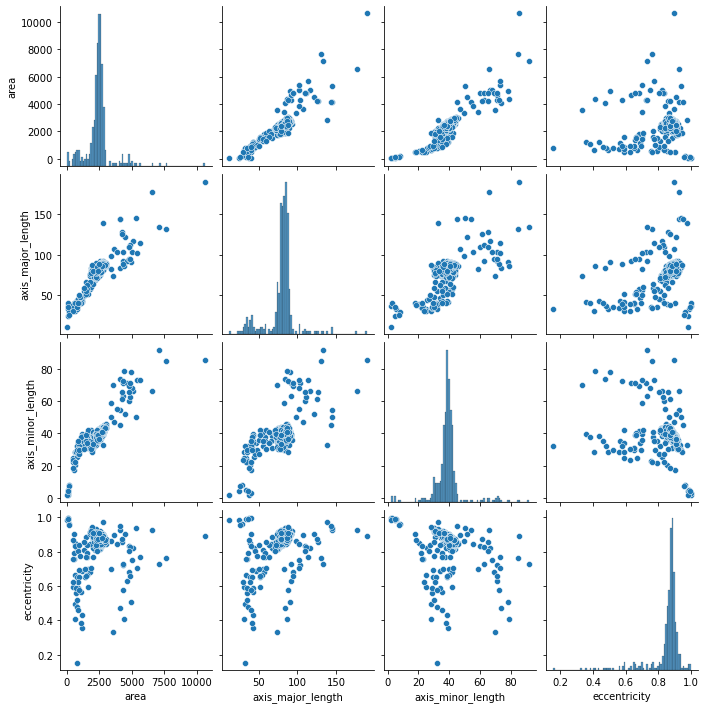

In [16]:
sns.pairplot(df)

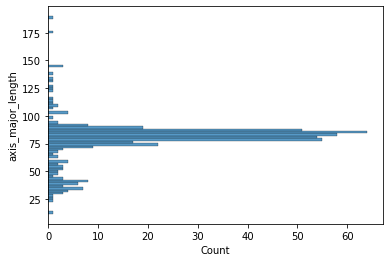

In [19]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=df, y="axis_major_length")
plt.show()

In [22]:
# Pandasデータフレームに含まれる検出ノイズを除去するため、
# 四分位範囲（Interquartile Range, IQR）を使用してフィルタリングします。

# IQRを計算する
Q1 = df['axis_major_length'].quantile(0.25)
Q3 = df['axis_major_length'].quantile(0.75)
IQR = Q3 - Q1

# 下限と上限を計算する
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 下限より小さい値または上限より大きい値を持つ行を削除する
filtered_df = df[(df['axis_major_length'] >= lower_bound) & (df['axis_major_length'] <= upper_bound)]

# フィルタリング後のデータを表示
filtered_df

,area,axis_major_length,axis_minor_length,eccentricity
0,2646.0,85.254134,41.015213,0.876669
1,2287.0,86.543921,34.237429,0.918420
2,2628.0,81.148629,41.565586,0.858857
3,2685.0,85.792475,40.327403,0.882636
4,2458.0,85.043518,37.942916,0.894954
...,...,...,...,...
438,2042.0,79.271079,33.303007,0.907471
439,2378.0,79.325459,38.784165,0.872326
441,2735.0,86.139815,40.850644,0.880397
442,4845.0,94.704422,71.343601,0.657644


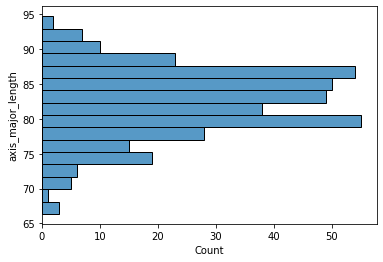

In [23]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=filtered_df, y="axis_major_length")
plt.show()
# だいぶすっきりしました。

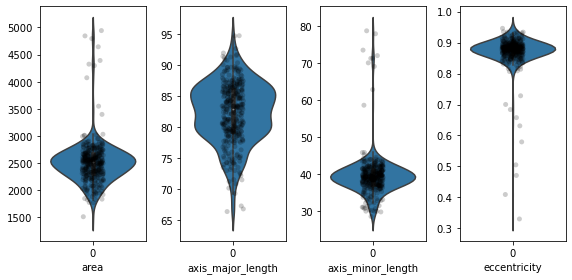

In [32]:
# area, axis_major_length, axis_minor_length, eccentricityの項目について描画します。
plt.figure(figsize=(10,4))
phenotype = ["area", "axis_major_length", "axis_minor_length", "eccentricity"]
for i, pheno in enumerate(phenotype):
    plt.subplot(1,len(phenotype)+1,i+1)
    sns.violinplot(data=filtered_df[pheno])
    sns.stripplot(data=filtered_df[pheno], color="black", alpha=0.2, jitter=True)
    plt.xlabel(pheno)
plt.tight_layout()


## 最後に

今回は、背景が黒色で種子が明るい色であったため、背景分離が容易でした。撮影する際には、種子をばらけて配置することで、測定精度が向上することが期待されます。近年、画像解析の初手として「機械学習！」「深層学習！」という風潮がありますが、撮影環境の最適化や基本的な画像解析手法の適切な選択によっても、研究に十分なデータを集めることが可能であることを心に留めてください。

しかし、多くの写真を短期間で撮影する必要があるため、種子の配置に時間をかけることができない、または背景の台紙を変えても種子と分離できないといった問題が発生する可能性があります。そのような場合には、機械学習（深層学習）を利用して処理することで、手間を省くことも可能です（ただし、モデルの作成・訓練コストは考慮外とします）。

また、ハンズオンの後半では、深層学習ベースで種子の計数・形状解析を行った事例についても紹介しますので、興味のある方はそちらもあわせてどうぞ。